Goal: Attempt to model a customer’s propensity to join our loyalty program

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

In [2]:
cc = pd.read_csv('../data/takehome/customers_data.csv').drop(['Unnamed: 0'],axis=1)
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 6 columns):
purch_amt                120000 non-null float64
gender                   120000 non-null object
card_on_file             120000 non-null object
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty                  120000 non-null bool
dtypes: bool(1), float64(3), object(2)
memory usage: 4.7+ MB


# Cleaning

In [3]:
cc.head(1)

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,male,no,31.0,35.0,False


In [4]:
cc.isnull().any()

purch_amt                False
gender                   False
card_on_file             False
age                      False
days_since_last_purch    False
loyalty                  False
dtype: bool

No null values, this is a good sign

Lets look at the distributions

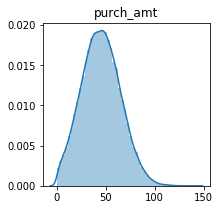

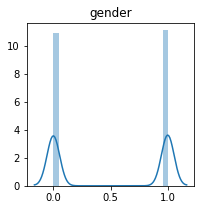

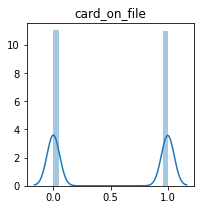

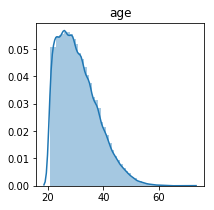

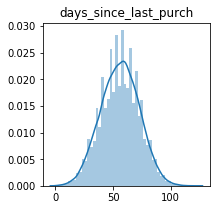

In [34]:
measurables = list(cc.columns[0:-1].values)
for i in measurables:
    plt.figure(figsize=(3,3))
    plt.title(i)
    sns.distplot(cc[i].values)
    plt.show()

In [5]:
cc['age'].min()

-9.0

The lowest age is -22. This is a very bad sign. It indicates there are values that need to be cleaned. I don't think 5 year old children are able to make purchases. Since 21 is the legal age to own a card, I will remove all rows that have ages under 21. <br><br>Purchase amount also appears to have negative values. I would need to learn more about the dataset to decide whether or not negative values are ok for purchase amount. In this case, my assumption is that anything 0 or less is not acceptable and will remove those values.<br><br> Days since last purchase should also not have any negative values. I want to fix this:

In [6]:
cc = cc[cc['age']>=21]
cc = cc[cc['purch_amt']>0]
cc = cc[cc['days_since_last_purch']>0]

# Exploring

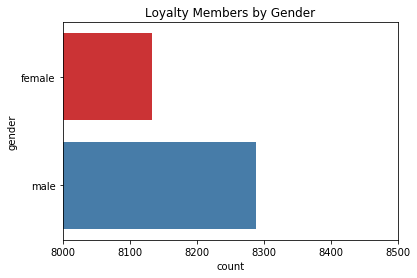

In [7]:
sns.countplot(y="gender", data=cc[cc['loyalty']==1], palette="Set1")
plt.xlim(8000,8500)
plt.title('Loyalty Members by Gender');

There is a slight difference between the number of men and women who have are loyalty subscribers (~200). Men appear to be slightly more likely to be members but it is not by significant number. Nonetheless, this is important to note.

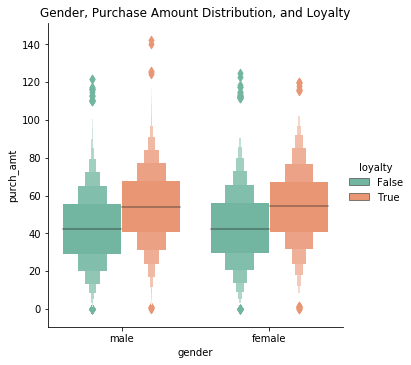

In [8]:
sns.catplot(x="gender", y="purch_amt", hue="loyalty", kind="boxen", palette='Set2',data=cc)
plt.title('Gender, Purchase Amount Distribution, and Loyalty');

There does not seem to be a difference between males and females with regards to purchase amount. Both males and females appear to have a relatively similar distributions. It does appear that both men and women are likely to be a loyalty member if they have larger purchases. men who are loyalty members appear to have a slightly bigger distribution of purchase amount.

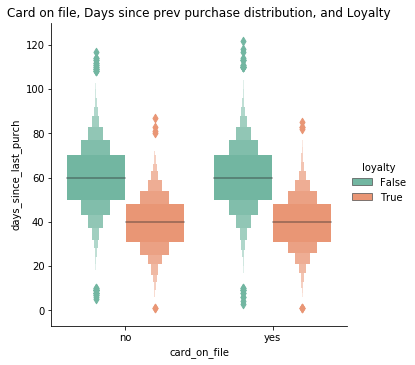

In [9]:
sns.catplot(x="card_on_file",y="days_since_last_purch",hue="loyalty",kind="boxen",palette='Set2',data=cc)
plt.title('Card on file, Days since prev purchase distribution, and Loyalty');

Having a card on file does not appear to affect the days since a previous purchase.

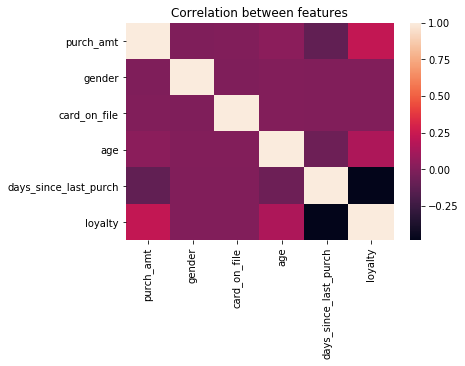

In [11]:
cc.gender = pd.Categorical(cc.gender).codes
cc.card_on_file = pd.Categorical(cc.card_on_file).codes
cc.loyalty = pd.Categorical(cc.loyalty).codes
sns.heatmap(cc.corr())
plt.title('Correlation between features');

After cleaning up the data, purchase amount and age appear to be the features that have the best positive correlation while days_since_last_purchase has some negative correlation to loyalty. A negative correlation makes sense because I believe frequent purchasers are more likely to be a loyalty member. And a low value for days_since_last_purchase would probably be more likely to have a loyalty membership than a high value.

In [12]:

for i in measurables:
    t, p = ttest_ind(cc[i][cc['loyalty']==0],cc[i][cc['loyalty']==1])
    print('{}:\nt:{} | p:{}\n'.format(i,t,p))

purch_amt:
t:-67.28751726276614 | p:0.0

gender:
t:-0.25201558165821825 | p:0.8010296482735997

card_on_file:
t:-0.5079229762626465 | p:0.6115087197960689

age:
t:-43.915595200693424 | p:0.0

days_since_last_purch:
t:159.22816582675313 | p:0.0



Gender and card_on_file have high p values but they are not normally distributed (they have binomial distribution). For the others, the difference between loyalty and non loyalty samples is statistically significant.

# Modeling

I believe that a logistic regression would be the best simple model for this data since we are dealing with binary target values and a mixture of discrete and continuous features. I will also do a multinomial naive bayes model, but because there are only two features with discrete values, I do not think it will perform as well.

In [13]:
trainingSet, testSet = train_test_split(cc, test_size=0.2)

In [14]:
logreg = LogisticRegression()
logreg.fit(trainingSet.drop(['loyalty'],axis=1),trainingSet['loyalty'])
pred_score = logreg.score(testSet.drop(['loyalty'],axis=1),testSet['loyalty'])
logreg_coef = logreg.coef_[0]
linreg = LinearRegression()
linreg.fit(trainingSet.drop(['loyalty'],axis=1),trainingSet['loyalty'])
linreg_coef = linreg.coef_

In [15]:
print('Calculated Weights for Logistic Regression (how much a feature influences the target):')
list(zip(measurables,logreg_coef))

Calculated Weights for Logistic Regression (how much a feature influences the target):


[('purch_amt', 0.03045876406354967),
 ('gender', -0.0075715795315142225),
 ('card_on_file', 0.0071600742014654925),
 ('age', 0.049862412788913894),
 ('days_since_last_purch', -0.10156192523055942)]

The weights appear to be very similar to my observations from the corr heatplot. Days_since_last purchase has a negative weight, while age and purchase_amt appear to have the strongest influence on the results.

In [35]:
nb = MultinomialNB()
nb.fit(trainingSet.drop(['loyalty'],axis=1),trainingSet['loyalty'])
nb_score = nb.score(testSet.drop(['loyalty'],axis=1),testSet['loyalty'])
print('Logistic Regression score: {:02f}'.format(pred_score))
print('Naive Bayes score: {:02f}'.format(nb_score))

Logistic Regression score: 0.844857
Naive Bayes score: 0.788998


The logistic regression baseline model did seem to perform better than the naive bayes model.

__Conclusion__

An increase in age seems to be the biggest factor for predicting if someone would be a loyalty member. Similarly, an increase in purchase amount also seems to be a very strong indicatory of the loyalty subscription. A decrease in days since the last purchase seems to be slightly relevant but much less so. Having a card on file even less so. There do seem to be more male loyalty subscribers, but not that much more.